## https://github.com/BCG-Gamma/facet
. sklearndf
# conda install -c bcg_gamma sklearndf 
# conda install sklearndf -c bcg_gamma -c conda-forge
. gamma-facet
## conda install gamma-facet -c bcg_gamma -c conda-forge



In [5]:
# standard imports
import pandas as pd
import numpy as np 
from sklearn.model_selection import RepeatedKFold

# some helpful imports from sklearndf
from sklearndf.pipeline import PipelineDF, ClassifierPipelineDF
from sklearndf.pipeline import RegressorPipelineDF
# from sklearndf.classification import RandomForestClassifierDF
from sklearndf.regression import RandomForestRegressorDF

# relevant FACET imports
from facet.data import Sample
from facet.selection import LearnerRanker, LearnerGrid
# target_ToolGID = 'PW_PIX'

In [7]:
# # load the diabetes dataset
df_train_orign = pd.read_csv('./data/TRCT_TrainingData_20210131.csv')
 
# df_train_orign = df_train_orign.loc[df_train_orign['TOOLG_ID']==target_ToolGID]
#df_train_orign['MFG_DATE'] = pd.to_datetime(test['MFG_DATE'],format='%Y%m%d') 
df_train_orign['MFG_DATE'] = df_train_orign['MFG_DATE'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

MRATIO_df = df_train_orign

#刪除columns 值是空的()
MRATIO_df = MRATIO_df.dropna(axis=1, how='all')
 
# #刪除rows ,target值是空的()
MRATIO_df = MRATIO_df[MRATIO_df['MOVE_QTY'].notna()]
MRATIO_df = MRATIO_df[MRATIO_df['NO_HOLD_QTY'].notna()]

MRATIO_df['TOOLG_ID']=MRATIO_df['TOOLG_ID'].astype("category").cat.codes

MRATIO_df['TRCT']= MRATIO_df['NO_HOLD_QTY']/MRATIO_df['MOVE_QTY']

MRATIO_df.info()

MRATIO_df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 96956 entries, 0 to 128681
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   MFG_DATE         96956 non-null  datetime64[ns]
 1   TOOLG_ID         96956 non-null  int16         
 2   IS_HOLIDAY       96956 non-null  float64       
 3   M_NUM            96956 non-null  float64       
 4   UP_TIME          96956 non-null  float64       
 5   C_UP_TIME        96955 non-null  float64       
 6   LOT_SIZE         96956 non-null  float64       
 7   C_LOT_SIZE       96955 non-null  float64       
 8   EQP_UTIL         96956 non-null  float64       
 9   C_EQP_UTIL       96955 non-null  float64       
 10  U                96866 non-null  float64       
 11  PROCESS_TIME     96956 non-null  float64       
 12  WIP_QTY          96956 non-null  float64       
 13  NO_HOLD_QTY      96956 non-null  float64       
 14  MOVE_QTY         96956 non-null  floa

MFG_DATE            0
TOOLG_ID            0
IS_HOLIDAY          0
M_NUM               0
UP_TIME             0
C_UP_TIME           1
LOT_SIZE            0
C_LOT_SIZE          1
EQP_UTIL            0
C_EQP_UTIL          1
U                  90
PROCESS_TIME        0
WIP_QTY             0
NO_HOLD_QTY         0
MOVE_QTY            0
ARRIVAL_WIP_QTY     0
RUN_WIP_RATIO       0
C_TC                1
HOLD_RATE           0
ENG_LOT_RATE        0
HOT_LOT_RATE        0
QUE_LOT_RATE        0
TRCT                0
dtype: int64

In [9]:
MRATIO_df

,TOOLG_ID,IS_HOLIDAY,M_NUM,UP_TIME,C_UP_TIME,LOT_SIZE,C_LOT_SIZE,EQP_UTIL,C_EQP_UTIL,U,...,NO_HOLD_QTY,MOVE_QTY,ARRIVAL_WIP_QTY,RUN_WIP_RATIO,C_TC,HOLD_RATE,ENG_LOT_RATE,HOT_LOT_RATE,QUE_LOT_RATE,TRCT
0,1,1.0000,1.0,1.000000,NaN,19.750000,NaN,0.122326,NaN,1.000000,...,0.0,79.0,2.250000,0.000000,NaN,0.793956,0.050633,0.000000,0.000000,0.000000
1,2,1.0000,6.0,0.922677,0.059257,24.966102,0.147734,0.870884,0.607786,0.293785,...,475.0,1473.0,69.708333,0.210526,0.697933,0.000000,0.000000,0.050916,0.016972,0.322471
3,3,1.0000,14.0,0.858888,0.073048,23.718535,0.114837,0.906203,0.409993,0.165904,...,1793.0,10365.0,453.000000,0.310669,0.531574,0.085203,0.002894,0.056536,0.118476,0.172986
4,4,1.0000,5.0,0.956914,0.057361,20.307229,0.125680,0.989448,0.354703,0.475904,...,1500.0,3371.0,159.375000,0.133373,1.102431,0.100466,0.033225,0.029071,0.000000,0.444972
5,5,1.0000,6.0,0.825667,0.083071,23.833333,0.097758,0.329915,1.077606,0.379630,...,100.0,429.0,13.708333,0.000000,10.706018,0.013139,0.009324,0.000000,0.000000,0.233100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128677,314,1.0527,4.0,1.000000,0.131216,22.975309,0.184263,0.938669,0.358812,0.729938,...,816.0,7444.0,316.875000,0.290865,4.664070,0.023909,0.003224,0.032644,0.545137,0.109618
128678,315,1.0527,2.0,0.943347,0.139095,24.356322,0.173815,0.886387,0.379976,0.873563,...,226.0,2119.0,76.625000,0.432900,10.406746,0.029508,0.000000,0.070788,0.200094,0.106654
128679,316,1.0527,1.0,1.000000,0.131215,25.000000,0.169339,0.006495,51.857578,1.000000,...,0.0,50.0,2.083333,0.000000,0.000000,0.973375,0.000000,0.000000,1.000000,0.000000
128680,317,1.0527,2.0,0.992220,0.132243,19.351724,0.218764,0.422822,0.796569,0.993103,...,203.0,5612.0,232.250000,0.057077,786.848358,0.622029,0.033321,0.041340,0.972737,0.036172


In [13]:

# drop_cols=['MFG_DATE']
# MRATIO_df = MRATIO_df.drop(drop_cols, axis=1)


In [14]:

print(MRATIO_df.isnull().sum())

TOOLG_ID           0
IS_HOLIDAY         0
M_NUM              0
UP_TIME            0
C_UP_TIME          0
LOT_SIZE           0
C_LOT_SIZE         0
EQP_UTIL           0
C_EQP_UTIL         0
U                  0
PROCESS_TIME       0
WIP_QTY            0
NO_HOLD_QTY        0
MOVE_QTY           0
ARRIVAL_WIP_QTY    0
RUN_WIP_RATIO      0
C_TC               0
HOLD_RATE          0
ENG_LOT_RATE       0
HOT_LOT_RATE       0
QUE_LOT_RATE       0
TRCT               0
dtype: int64


In [15]:
MRATIO_df = MRATIO_df.dropna() # 刪除null值   
print(MRATIO_df)
# create FACET sample object
MRATIO_sample = Sample(observations=MRATIO_df, target_name="TRCT") 
print(MRATIO_df)

        TOOLG_ID  IS_HOLIDAY  M_NUM   UP_TIME  C_UP_TIME   LOT_SIZE  \
1              2      1.0000    6.0  0.922677   0.059257  24.966102   
3              3      1.0000   14.0  0.858888   0.073048  23.718535   
4              4      1.0000    5.0  0.956914   0.057361  20.307229   
5              5      1.0000    6.0  0.825667   0.083071  23.833333   
6              7      1.0000    4.0  0.980924   0.067564  20.933333   
...          ...         ...    ...       ...        ...        ...   
128677       314      1.0527    4.0  1.000000   0.131216  22.975309   
128678       315      1.0527    2.0  0.943347   0.139095  24.356322   
128679       316      1.0527    1.0  1.000000   0.131215  25.000000   
128680       317      1.0527    2.0  0.992220   0.132243  19.351724   
128681       318      1.0527   18.0  0.996697   0.131649  23.361350   

        C_LOT_SIZE  EQP_UTIL  C_EQP_UTIL         U  ...  NO_HOLD_QTY  \
1         0.147734  0.870884    0.607786  0.293785  ...        475.0   
3  

In [2]:

# create a (trivial) pipeline for a random forest regressor
rnd_forest_reg = RegressorPipelineDF(
    regressor=RandomForestRegressorDF(random_state=42)
)

# define grid of models which are "competing" against each other
rnd_forest_grid = [
    LearnerGrid(
        pipeline=rnd_forest_reg,
        learner_parameters={
            "min_samples_leaf": [8, 11, 15]
        }
    ),
]

# create repeated k-fold CV iterator
rkf_cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# rank your candidate models by performance (default is mean CV score - 2*SD)
ranker = LearnerRanker(
    grids=rnd_forest_grid, cv=rkf_cv, n_jobs=-3
).fit(sample=MRATIO_sample)

# get summary report
ranker.summary_report()

NameError: name 'MRATIO_sample' is not defined

In [33]:
# fit the model inspector
from facet.inspection import LearnerInspector
inspector = LearnerInspector(n_jobs=-3)
inspector.fit(crossfit=ranker.best_model_crossfit_)

## https://github.com/chrisrichgruber/gamma-facet/blob/main/Titanic%20BCG%20Gamma%20Facet.ipynb

In [ ]:
f_importance

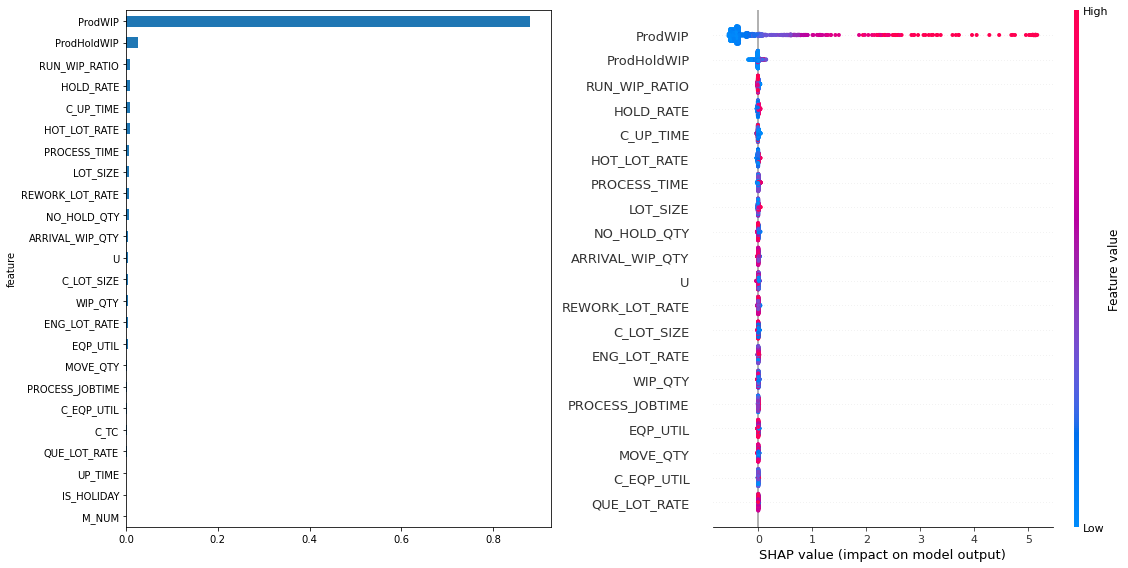

In [29]:
import matplotlib.pyplot as plt
import shap

# FACET feature importance
f_importance = inspector.feature_importance()
plt.subplot(1, 2, 1)
f_importance.sort_values().plot.barh()

# get some info for standard SHAP model inspection
shap_data = inspector.shap_plot_data()

# standard SHAP summary plot using the shap package
plt.subplot(1, 2, 2)
shap.summary_plot(shap_values=shap_data.shap_values, features=shap_data.features, show=False, plot_size=(16.0, 8.0))
plt.tight_layout()

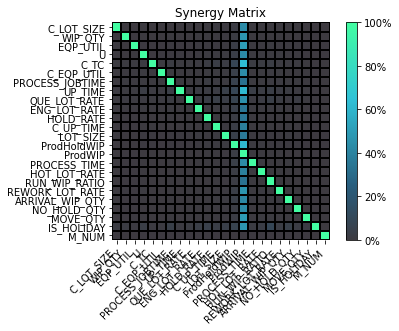

In [20]:
# visualise synergy as a matrix
from pytools.viz.matrix import MatrixDrawer
synergy_matrix = inspector.feature_synergy_matrix()
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Synergy Matrix")
#矩陣列 — 需要依賴其他特徵程度
#矩陣行 — 重要被依賴程度 (需要搭配 才有預測意義。)
#必須謹慎考慮高度協同的特徵，因為它們搭配在一起可高度預測結果

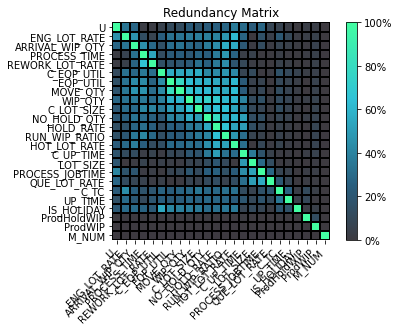

In [21]:
# visualise redundancy as a matrix
redundancy_matrix = inspector.feature_redundancy_matrix()
MatrixDrawer(style="matplot%").draw(redundancy_matrix, title="Redundancy Matrix")

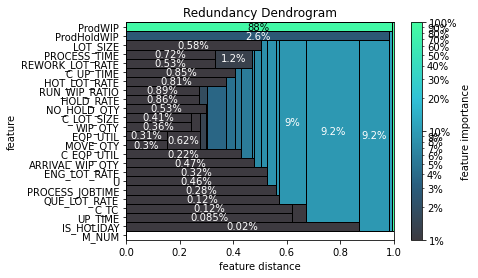

In [22]:
# visualise redundancy using a dendrogram
from pytools.viz.dendrogram import DendrogramDrawer
redundancy = inspector.feature_redundancy_linkage()
DendrogramDrawer().draw(data=redundancy, title="Redundancy Dendrogram")

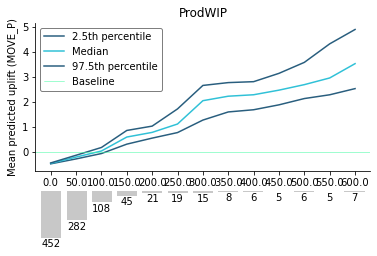

In [34]:
# FACET imports
from facet.validation import BootstrapCV
from facet.crossfit import LearnerCrossfit
from facet.simulation import UnivariateUpliftSimulator
from facet.simulation.partition import ContinuousRangePartitioner
from facet.simulation.viz import SimulationDrawer

# create bootstrap CV iterator
bscv = BootstrapCV(n_splits=1000, random_state=42)

# create a bootstrap CV crossfit for simulation using best model
boot_crossfit = LearnerCrossfit(
    pipeline=ranker.best_model_,
    cv=bscv,
    n_jobs=-3,
    verbose=False,
).fit(sample=MRATIO_sample)

SIM_FEAT = "ProdWIP"
simulator = UnivariateUpliftSimulator(crossfit=boot_crossfit, n_jobs=-3)

# split the simulation range into equal sized partitions
partitioner = ContinuousRangePartitioner()

# run the simulation
simulation = simulator.simulate_feature(feature_name=SIM_FEAT, partitioner=partitioner)

# visualise results
SimulationDrawer().draw(data=simulation, title=SIM_FEAT)

In [8]:
 
# from sklearndf.transformation import SimpleImputerDF
# want_col =[ 'IS_HOLIDAY', 'M_NUM', 'UP_TIME', 'C_UP_TIME', 'LOT_SIZE',
#        'C_LOT_SIZE', 'EQP_UTIL', 'C_EQP_UTIL', 'U', 'PROCESS_TIME',
#        'PROCESS_JOBTIME', 'WIP_QTY', 'NO_HOLD_QTY', 'MOVE_QTY',
#        'ARRIVAL_WIP_QTY', 'RUN_WIP_RATIO', 'C_TC', 'HOLD_RATE', 'ENG_LOT_RATE',
#        'HOT_LOT_RATE', 'REWORK_LOT_RATE', 'QUE_LOT_RATE', 'ProdWIP',
#        'ProdHoldWIP']
# Target= 'MOVE_P'
# step =[('impute',SimpleImputerDF()),
#     #Add any othere step
# ]
 

In [15]:

# # create a (trivial) pipeline for a random forest regressor
# rnd_forest_reg = RegressorPipelineDF(
#     regressor=RandomForestRegressorDF(random_state=42)
# )

# # define grid of models which are "competing" against each other
# rnd_forest_grid = [
#     LearnerGrid(
#         pipeline=rnd_forest_reg,
#         learner_parameters={
#             "min_samples_leaf": [8, 11, 15]
#         }
#     ),
# ]

# # create repeated k-fold CV iterator
# rkf_cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# # rank your candidate models by performance (default is mean CV score - 2*SD)
# ranker = LearnerRanker(
#     grids=rnd_forest_grid, cv=rkf_cv, n_jobs=-3
# ).fit(sample=MRATIO_sample)

# # get summary report
# ranker.summary_report()

# Gamma Facet的第一個特徵：找出重要抓手

In [7]:
# # fit the model inspector
# from facet.inspection import LearnerInspector
# inspector = LearnerInspector(n_jobs=-3)
# inspector.fit(crossfit=ranker.best_model_crossfit_)
# # visualise synergy as a matrix
# from pytools.viz.matrix import MatrixDrawer
# synergy_matrix = inspector.feature_synergy_matrix()
# MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Synergy Matrix")

# Synergy

# Redundancy

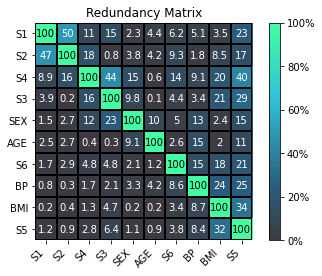

In [9]:
# visualise redundancy as a matrix
redundancy_matrix = inspector.feature_redundancy_matrix()
MatrixDrawer(style="matplot%").draw(redundancy_matrix, title="Redundancy Matrix")

# Clustering redundancy

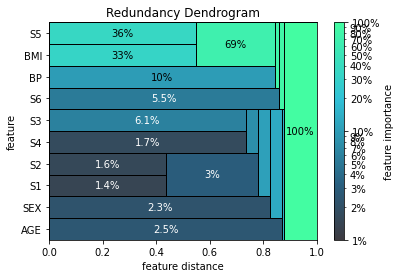

In [10]:
# visualise redundancy using a dendrogram
from pytools.viz.dendrogram import DendrogramDrawer
redundancy = inspector.feature_redundancy_linkage()
DendrogramDrawer().draw(data=redundancy, title="Redundancy Dendrogram")

# Model Simulation

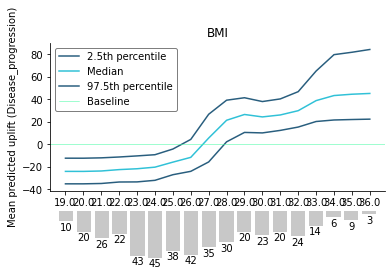

In [11]:
# FACET imports
from facet.validation import BootstrapCV
from facet.crossfit import LearnerCrossfit
from facet.simulation import UnivariateUpliftSimulator
from facet.simulation.partition import ContinuousRangePartitioner
from facet.simulation.viz import SimulationDrawer

# create bootstrap CV iterator
bscv = BootstrapCV(n_splits=1000, random_state=42)

# create a bootstrap CV crossfit for simulation using best model
boot_crossfit = LearnerCrossfit(
    pipeline=ranker.best_model_,
    cv=bscv,
    n_jobs=-3,
    verbose=False,
).fit(sample=MRATIO_sample)

SIM_FEAT = "BMI"
simulator = UnivariateUpliftSimulator(crossfit=boot_crossfit, n_jobs=-3)

# split the simulation range into equal sized partitions
partitioner = ContinuousRangePartitioner()

# run the simulation
simulation = simulator.simulate_feature(feature_name=SIM_FEAT, partitioner=partitioner)

# visualise results
SimulationDrawer().draw(data=simulation, title=SIM_FEAT)